# Librerías necesarias

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import sys
import umap
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

In [21]:
with open("../data/cleaned_data/cleaned_arab_quran.txt", encoding="utf-8") as f:
    lines_ar = f.readlines()

df_ar = pd.DataFrame(lines_ar, columns=["text"])
df_ar["text"] = df_ar["text"].str.strip()


with open("../data/raw_data/english_quran.txt", "r") as f:
    lines_eng = f.readlines()

df_eng = pd.DataFrame(lines_eng, columns=["text"])
df_eng["text"] = df_eng["text"].str.strip()

Cargamos los modelos de fasttext obtenidos en el otro notebook

In [3]:
fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

In [4]:
fasttext_english = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

## Clustering de capítulos con HDBSCAN
Para este nuevo apartado, usaremos el mismo modelo de embeddings usado anteriormente (fasttext) utilizaremos UMAP para la reducción de dimensionalidad. Ya que supuestamente funciona mejor para embeddings que el PCA (usado antes) y usaremos el modelo de clustering HDBSCAN para visualizar los grupos de capítulos más similares en un espacio bidimensional.

En árabe primero:

In [11]:
df_ft = pd.DataFrame(lines_ar, columns=["text"])
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]
df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: fasttext_arabe.get_sentence_vector(x))
df_ft[["capitulo", "verso", "texto"]] = df_ft["text"].str.split("|", expand=True)
df_ft["capitulo"] = df_ft["capitulo"].astype(int)
df_ft.drop(columns=["text"], inplace=True)
df_ft.head()


,arab_embeddings,capitulo,verso,texto
0,"[0.018815823, 0.0005708956, 0.04486502, 0.0159...",1,1,بسم الله الرحمن الرحيم
1,"[-0.03129977, -0.0010722355, -0.0818935, 0.039...",1,2,الحمد لله رب العالمين
2,"[0.015483162, -0.019777045, 0.026550695, 0.020...",1,3,الرحمن الرحيم
3,"[0.0008555238, 0.050946265, -0.0728254, 0.0180...",1,4,مالك يوم الدين
4,"[0.006192082, 0.045709927, -0.15634888, 0.0139...",1,5,اياك نعبد واياك نستعين


In [12]:
embeddings_cap_ar = (
    df_ft.groupby("capitulo")["arab_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_ar.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
print(embeddings_cap_ar.head(5))

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
   capitulo                                    arab_embeddings
0         1  [0.004738839, 0.025171248, -0.06663668, 0.0143...
1         2  [-0.0033496504, 0.044835925, -0.091665246, 0.0...
2         3  [-0.002705321, 0.045411877, -0.0871832, 0.0110...
3         4  [-0.0093168095, 0.046683427, -0.092147924, 0.0...
4         5  [-0.0041136346, 0.04765432, -0.09723907, 0.012...


In [13]:
# Ahora vamos a reducir su dimensionalidad con UMAP
X = np.vstack(embeddings_cap_ar["arab_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer.fit_transform(X_scaled)

/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Agrupación con HDBSCAN

In [14]:
hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_ar["cluster"] = labels

/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
for c in sorted(embeddings_cap_ar["cluster"].unique()):
    #if c == -1: # No ha encontrado cluster el capítulo
    #    print(f"Capítulo sin cluster")
    for cl in embeddings_cap_ar["cluster"].unique():
        print(f"Cluster {cl}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == cl, 'capitulo'].tolist()}")

Cluster 5: [1, 67, 81, 97, 106, 108, 110, 114]
Cluster 6: [2, 3, 5, 60]
Cluster 2: [4, 33, 48, 65]
Cluster 8: [6, 10, 21, 23, 27, 28, 34, 36, 43, 56]
Cluster 12: [7, 29, 40, 41, 46, 105]
Cluster -1: [8, 25, 32, 38, 50, 52, 53, 55, 61, 70, 71, 76, 78, 82, 84, 87, 88, 89, 93, 101, 102, 107, 112]
Cluster 3: [9, 47, 58, 63]
Cluster 9: [11, 12, 17, 18, 19, 20, 69, 72, 73, 74, 75, 90, 94, 96, 109]
Cluster 1: [13, 31, 35, 42, 59, 85, 100]
Cluster 10: [14, 79, 80, 91, 92, 99, 104, 111, 113]
Cluster 11: [15, 26, 37, 44, 54]
Cluster 0: [16, 30, 39, 45, 86]
Cluster 7: [22, 24, 49, 57, 62, 64]
Cluster 13: [51, 68, 77, 83]
Cluster 4: [66, 95, 98, 103]
Cluster 5: [1, 67, 81, 97, 106, 108, 110, 114]
Cluster 6: [2, 3, 5, 60]
Cluster 2: [4, 33, 48, 65]
Cluster 8: [6, 10, 21, 23, 27, 28, 34, 36, 43, 56]
Cluster 12: [7, 29, 40, 41, 46, 105]
Cluster -1: [8, 25, 32, 38, 50, 52, 53, 55, 61, 70, 71, 76, 78, 82, 84, 87, 88, 89, 93, 101, 102, 107, 112]
Cluster 3: [9, 47, 58, 63]
Cluster 9: [11, 12, 17, 18, 19,

Mostramos los resultados:

/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


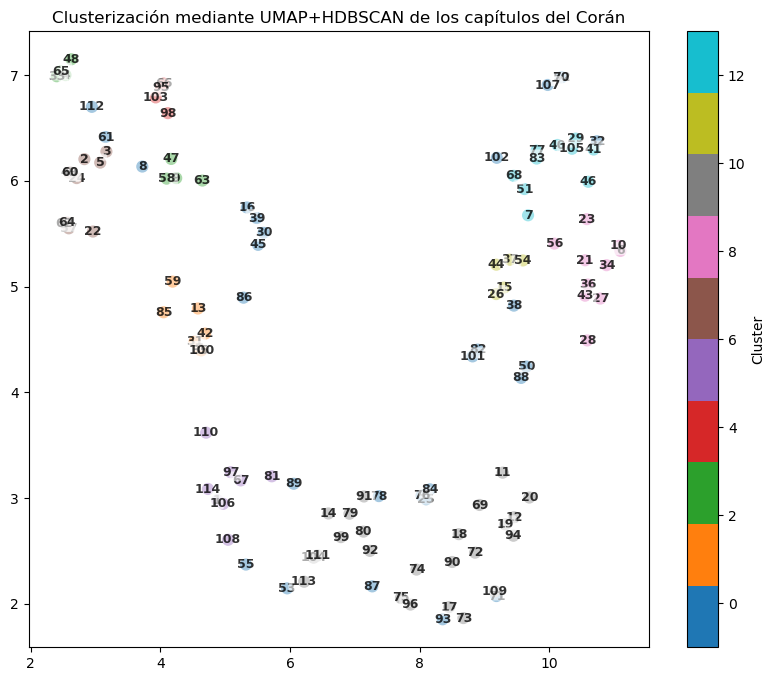

In [16]:
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_ar["capitulo"]):
    plt.text(
        X_2D[i, 0],
        X_2D[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán")
plt.colorbar(label="Cluster")
plt.show()

En el caso de la clusterización de capítulos en inglés, lo haremos directamente ya que lo hemos explicado más detenidamente en el ejemplo árabe.

In [23]:
df_en = pd.DataFrame(lines_eng, columns=["text"])
df_en["text"] = df_en["text"].str.strip()
df_en = df_en[df_en["text"].str.contains(r"[A-Za-z]")]
df_en["eng_embeddings"] = df_en["text"].apply(lambda x: fasttext_english.get_sentence_vector(x))
df_en[["capitulo", "verso", "texto"]] = df_en["text"].str.split("|", expand=True)
df_en["capitulo"] = pd.to_numeric(df_en["capitulo"], errors="coerce").fillna(0).astype(int)
df_en["verso"] = pd.to_numeric(df_en["verso"], errors="coerce").fillna(0).astype(int)
df_en = df_en[df_en["verso"] != 0]
df_en.drop(columns=["text"], inplace=True)
df_en.head()


,eng_embeddings,capitulo,verso,texto
0,"[-0.0035342134, -0.046359193, -0.008954853, -0...",1,1,"In the name of Allah, the Entirely Merciful, t..."
1,"[-0.026927117, -0.026981857, 0.0028041839, -0....",1,2,"[All] praise is [due] to Allah, Lord of the wo..."
2,"[0.015289197, -0.032068633, 0.0020112507, -0.0...",1,3,"The Entirely Merciful, the Especially Merciful,"
3,"[-0.044878926, -0.057493716, 0.011219065, -0.0...",1,4,Sovereign of the Day of Recompense.
4,"[-0.0632382, -0.021817876, 0.0015239015, -0.05...",1,5,It is You we worship and You we ask for help.


Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
Capítulo sin cluster
Cluster 5: [1, 67, 81, 97, 106, 108, 110, 114]
Cluster 6: [2, 3, 5, 60]
Cluster 2: [4, 33, 48, 65]
Cluster 8: [6, 10, 21, 23, 27, 28, 34, 36, 43, 56]
Cluster 12: [7, 29, 40, 41, 46, 105]
Cluster -1: [8, 25, 32, 38, 50, 52, 53, 55, 61, 70, 71, 76, 78, 82, 84, 87, 88, 89, 93, 101, 102, 107, 112]
Cluster 3: [9, 47, 58, 63]
Cluster 9: [11, 12, 17, 18, 19, 20, 69, 72, 73, 74, 75, 90, 94, 96, 109]
Cluster 1: [13, 31, 35, 42, 59, 85, 100]
Cluster 10: [14, 79, 80, 91, 92, 99, 104, 111, 113]
Cluster 11: [15, 26, 37, 44, 54]
Cluster 0: [16, 30, 39, 45, 86]
Cluster 7: [22, 24, 49, 57, 62, 64]
Cluster 13: [51, 68, 77, 83]
Cluster 4: [66, 95, 98, 103]
Cluster 5: [1, 67, 81, 97, 106, 108, 110, 114]
Cluster 6: [2, 3, 5, 60]
Cluster 2: [4, 33, 48, 65]
Cluster 8: [6, 10, 21, 23, 27, 28, 34, 36, 43, 56]
Cluster 12: [7, 29, 40, 41, 46, 105]
Cluster -1: [8, 25, 32, 38, 50, 52, 53, 55, 61, 70, 71, 76, 78, 82

/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/unai-olaizola-osa/miniconda3/envs/coran-nlp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


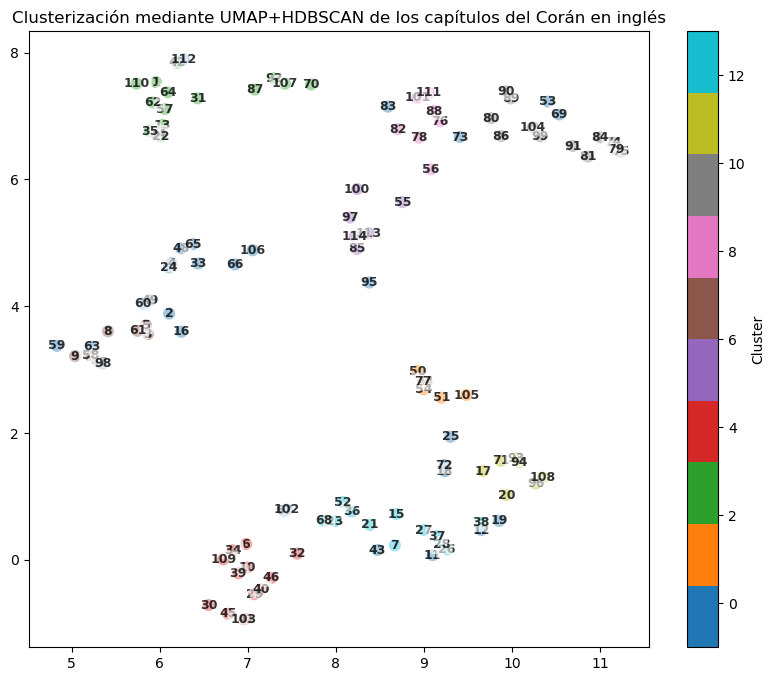

In [26]:
embeddings_cap_eng = (
    df_en.groupby("capitulo")["eng_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_eng.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
X = np.vstack(embeddings_cap_eng["eng_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer.fit_transform(X_scaled)

hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_eng["cluster"] = labels


for c in sorted(embeddings_cap_ar["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulo sin cluster")
    for cl in embeddings_cap_ar["cluster"].unique():
        print(f"Cluster {cl}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == cl, 'capitulo'].tolist()}")
        
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_eng["capitulo"]):
    plt.text(
        X_2D[i, 0],
        X_2D[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en inglés")
plt.colorbar(label="Cluster")
plt.show()